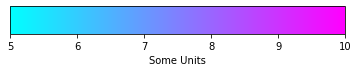

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.cool
norm = mpl.colors.Normalize(vmin=5, vmax=10)

cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('Some Units')
fig.savefig("colorbar.png")

Load the file according to the parameters

In [23]:
def log_file_path(memtable_size,cpu_count,storage_device="StorageMaterial.NVMeSSD",workload_size=100,prefix="Resources/"):
    return prefix + str(workload_size) +"GB/" \
           + "%s/%s/%s" % (
               "StorageMaterial."+material,
               str(cpu_count)+"CPU",
               str(memtable_size)+"MB")
# you can test it like this

print(log_file_path(32,12,"StorageMaterial.NVMeSSD"))

Resources/100GB/StorageMaterial.NVMeSSD/12CPU/32MB


List all files according to the parameter lists

In [28]:
# materials = ['NVMeSSD','SATASSD','PM']
materials = ['NVMeSSD']
cpu_count_array = [12]
memtable_size_array = [32]

import os
import glob
def find_log_file(log_dir):
    log_file = [filename for filename in glob.glob(
                log_dir+"/**") if "LOG" in filename][0]
    return log_file

log_files = []

for material in materials: 
    for cpu_count in cpu_count_array: 
        for memtable_size in memtable_size_array:
            log_dir = log_file_path(memtable_size,cpu_count,
                                  "StorageMaterial."+material)
            log_files.append(find_log_file(log_dir))

In [41]:
# importing and macro definition

import re
import json
job_id_dict = {}
event_row_dict = {}
EVENTS_NEED_COLLECTED = ['compaction_started','compaction_finished']

for event in EVENTS_NEED_COLLECTED:
    event_row_dict[event] = {}
    job_id_dict[event] = []

choose the first file from the list

ps: the reason for use a dictation instead of a list to store the job id is for further modification, maybe we need to 
monitor the flush or other kinds of job.

In [43]:
file = log_files[0]

file_content = open(file,"r").readlines()

for line in file_content:
    line = re.search('(\{.+\})', line)
    if line:
        try:
            log_row = json.loads(line[0])
            job_id = int(log_row['job'])
            current_event = log_row['event']
            if current_event in EVENTS_NEED_COLLECTED:
                if job_id not in job_id_dict[current_event]:
                    event_row_dict[current_event][job_id] = []
                    job_id_dict[current_event].append(job_id)
                else:
                    event_row_dict[current_event][job_id].append(log_row)
        except json.decoder.JSONDecodeError:
            pass
        

Now paint it out

In [71]:
class CompactionDetail:
    job_id=0
    compaction_start_micro=0
    compaction_latency_micro=0
    compaction_cpu_micro=0
    compaction_reason=""
    
compaction_reason_dict = {}
compaction_latencies = []
compaction_cpu_time = []
# group the compaction according to the reason
for compaction_job in job_id_dict['compaction_started']:    
    compaction_start_row = event_row_dict['compaction_started'][compaction_job][0]
    compaction_finish_row = event_row_dict['compaction_finished'][compaction_job][0]
    current_reason = compaction_start_row['compaction_reason']
    
    if current_reason not in compaction_reason_dict:
        compaction_reason_dict[current_reason] = []
    else:
        compaction_reason_dict[current_reason].append(compaction_job)
    compaction_latencies.append(compaction_finish_row['compaction_time_micros'])
    compaction_cpu_time.append(compaction_finish_row['compaction_time_cpu_micros'])
reason_count = len(compaction_reason_dict.keys())



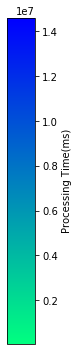

In [74]:
# we need reason_count + 1 subfigures,
import matplotlib.pyplot as plt
import matplotlib as mpl

fig, color_bar = plt.subplots(figsize=(0.5, 6))
# fig.subplots_adjust(left=0.5)

cmap = mpl.cm.winter_r
norm = mpl.colors.Normalize(vmin=min(compaction_cpu_time), vmax=max(compaction_cpu_time))

cb1 = mpl.colorbar.ColorbarBase(color_bar, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('Processing Time(ms)')
fig.savefig("colorbar.png")